In [ ]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
### Define the path to the file (a string in a variable 'db_file')
db_file = '../../data/astronomers_import.db'

In [203]:
### Créer une connexion vers la base de données
# Attention: si la base de données n'existe pas, elle est créée à l'endroit indiqué.
# Ce qui est une manière de la créer si souhaité
try:
    cn = sql.connect(db_file)
except Exception as e:
    print(e)    


In [204]:
### La requête à effectuer
# P..
q1 = """
WITH tw1 AS (
SELECT natio_code, SUM(eff) as effectif_tot
from code_nationality_country
GROUP BY natio_code )
SELECT birthyear, tw1.natio_code, effectif_tot
FROM dbp_person_countries dpc 
   JOIN code_nationality_country cnc ON cnc.natio_country = dpc.natio_country 
   JOIN tw1 ON tw1.natio_code = cnc.natio_code 
WHERE LENGTH(cnc.natio_code) > 0
ORDER BY birthyear ;   
"""

In [205]:
c_df= pd.read_sql_query(q1, cn)
cn.close()
c_df.head()

,birthyear,natio_code,effectif_tot
0,1380,Austrian,72
1,1380,Austrian,72
2,1380,Austrian,72
3,1380,Austrian,72
4,1404,Italian,219


In [206]:
print(c_df.birthyear.min(), c_df.birthyear.max())

1380 1993


In [207]:
### Changer l'ordre de tri des données et exclure les petits effectifs
c_df = c_df[c_df.effectif_tot > 10].sort_values(by=['natio_code','birthyear'])
c_df

,birthyear,natio_code,effectif_tot
194,1731,American,664
195,1731,American,664
215,1740,American,664
268,1773,American,664
310,1789,American,664
...,...,...,...
2595,1961,Swiss,56
2621,1963,Swiss,56
2662,1966,Swiss,56
2663,1966,Swiss,56


In [210]:
### Tableau avec les effectifs généraux
dc_df = c_df[['natio_code','effectif_tot']].groupby('natio_code').max()
dc_df

,effectif_tot
natio_code,
American,664
Argentinian,18
Austrian,72
British,300
Dutch,94
French,329
German,369
Indian,112
Italian,219


<Axes: ylabel='natio_code'>

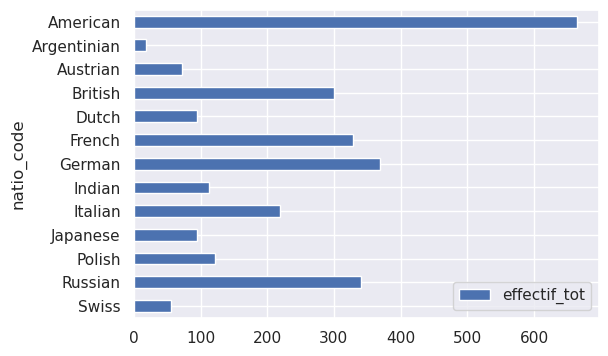

In [212]:
dc_df.sort_index(ascending=False).plot(kind='barh', figsize=(6,4))


<Axes: ylabel='natio_code'>

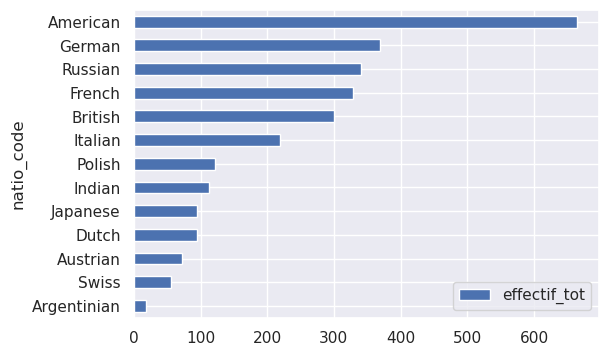

In [211]:
dc_df.sort_values(by='effectif_tot').plot(kind='barh', figsize=(6,4))

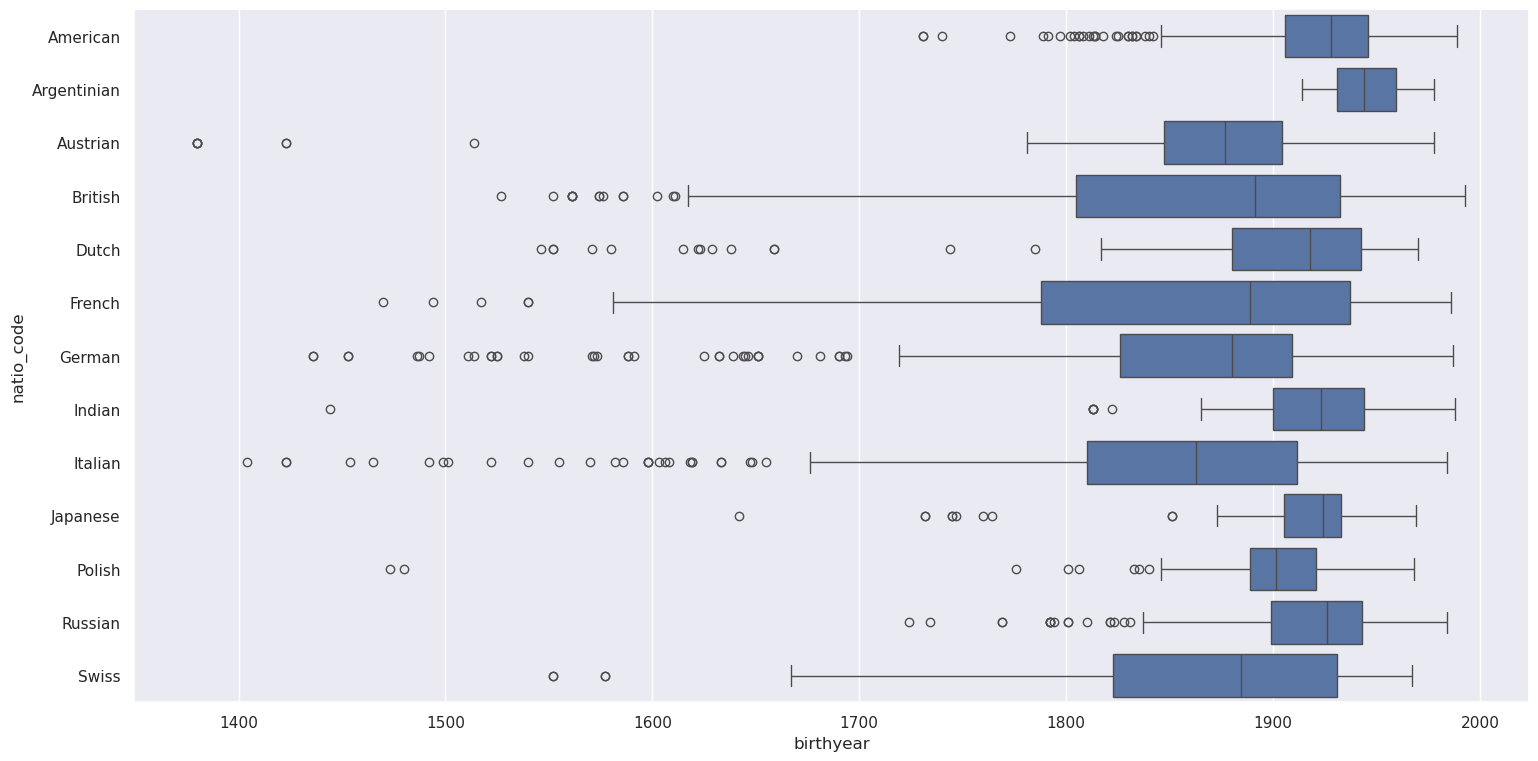

In [213]:
sns.set_theme(rc={'figure.figsize':(18,9)})
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear)
plt.show()

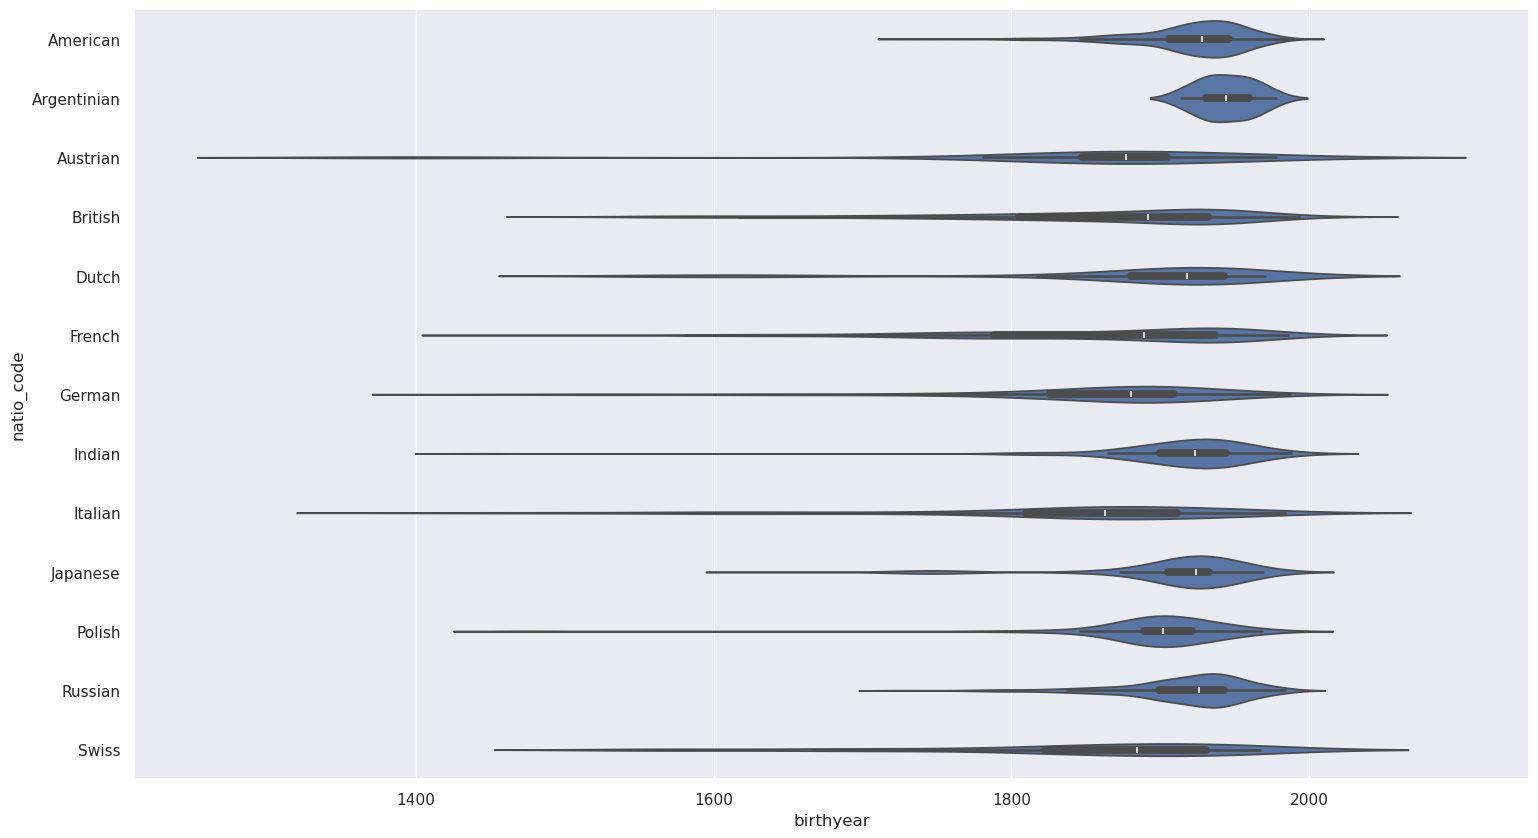

In [214]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})
sns.violinplot(y='natio_code', x='birthyear', data=c_df)
plt.show()

/tmp/ipykernel_516625/1037913549.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, scale='count')


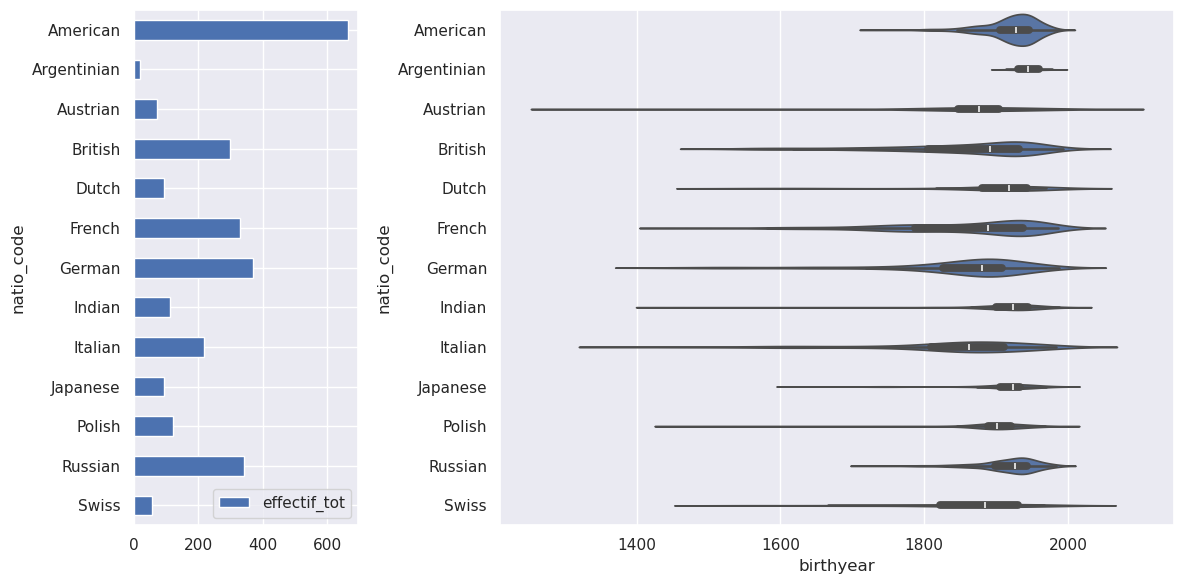

In [215]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6),  width_ratios=[1, 3])
gd_df = c_df[['natio_code','effectif_tot']].groupby(by=['natio_code']).max()\
      .sort_index(ascending=False).plot(kind='barh', figsize=(12,6), ax=ax1)

#sns.set_theme(rc={'figure.figsize':(18,10)})
ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, scale='count')

fig.tight_layout()
plt.show()

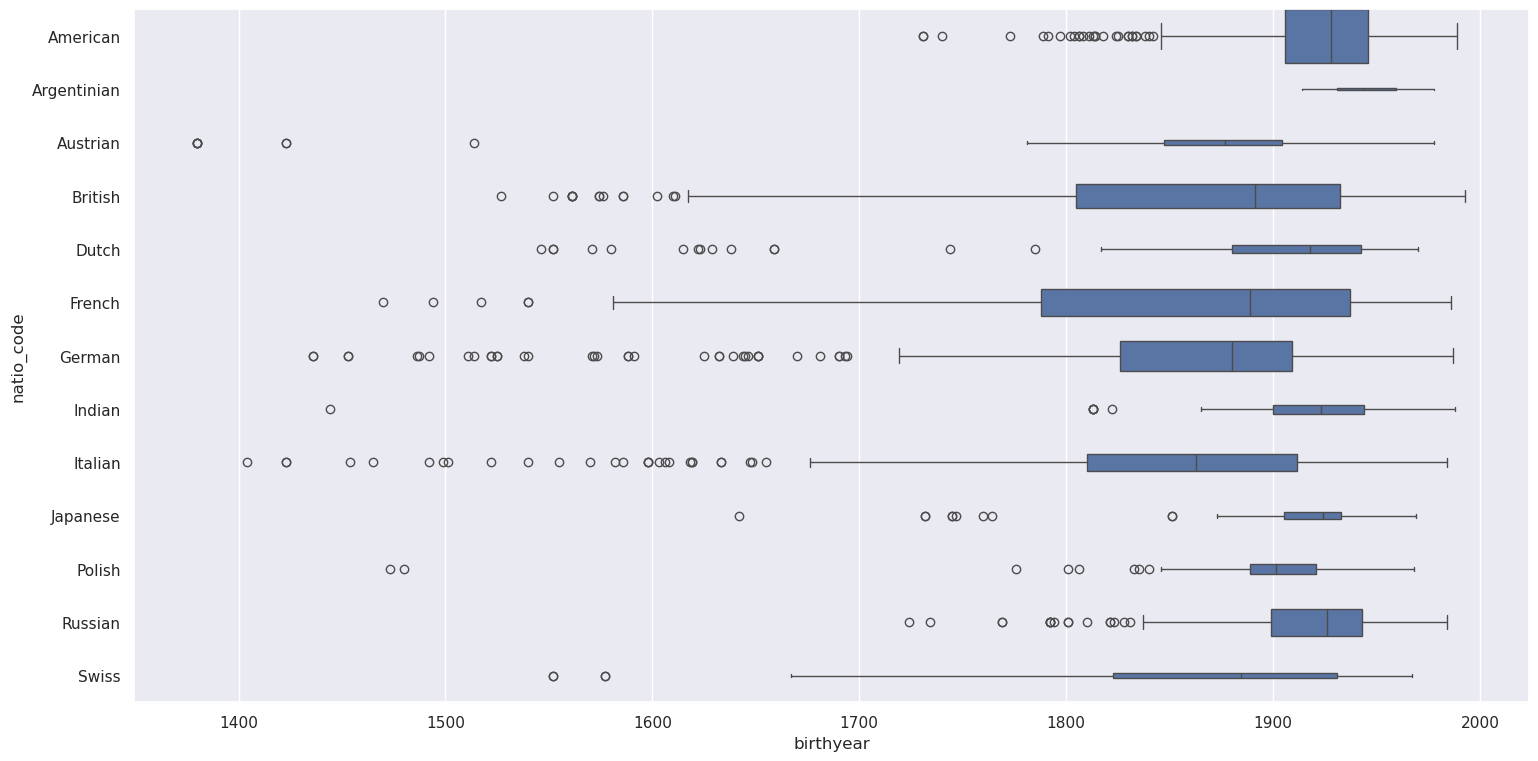

In [218]:
sns.set_theme(rc={'figure.figsize':(18,9)})

counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear, width=widths)
plt.show()

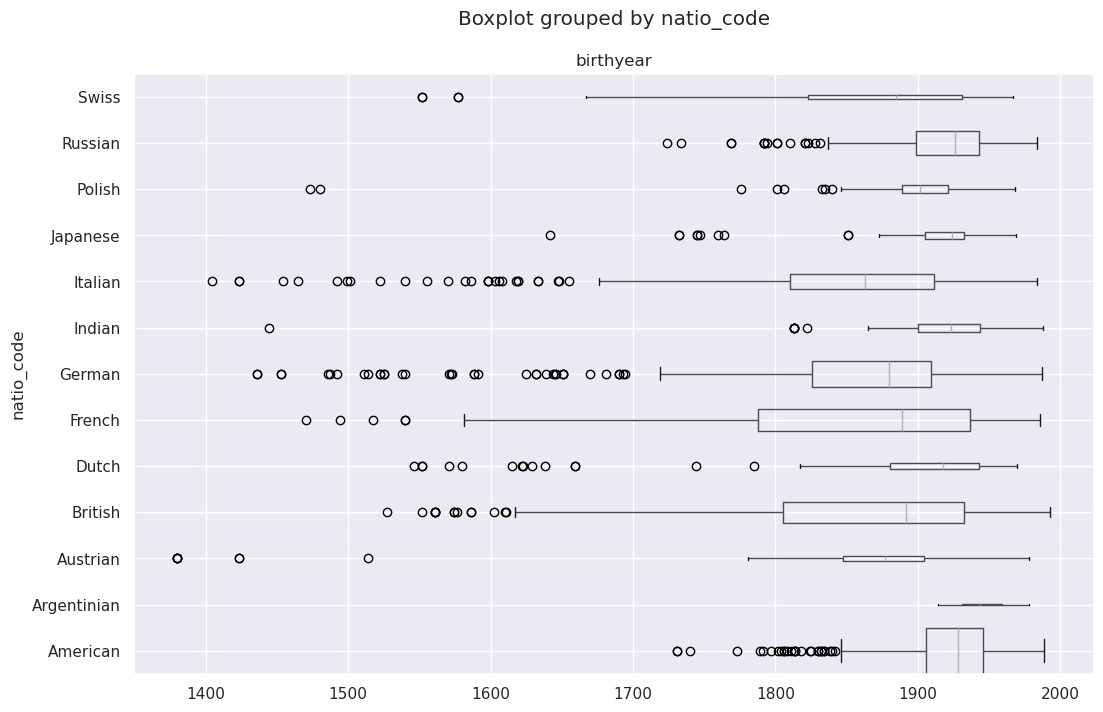

In [229]:
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
c_df.sort_values(by='natio_code', ascending=True).boxplot(column='birthyear', by='natio_code',  
          vert=False, widths=widths, figsize=(12,8))
plt.show()

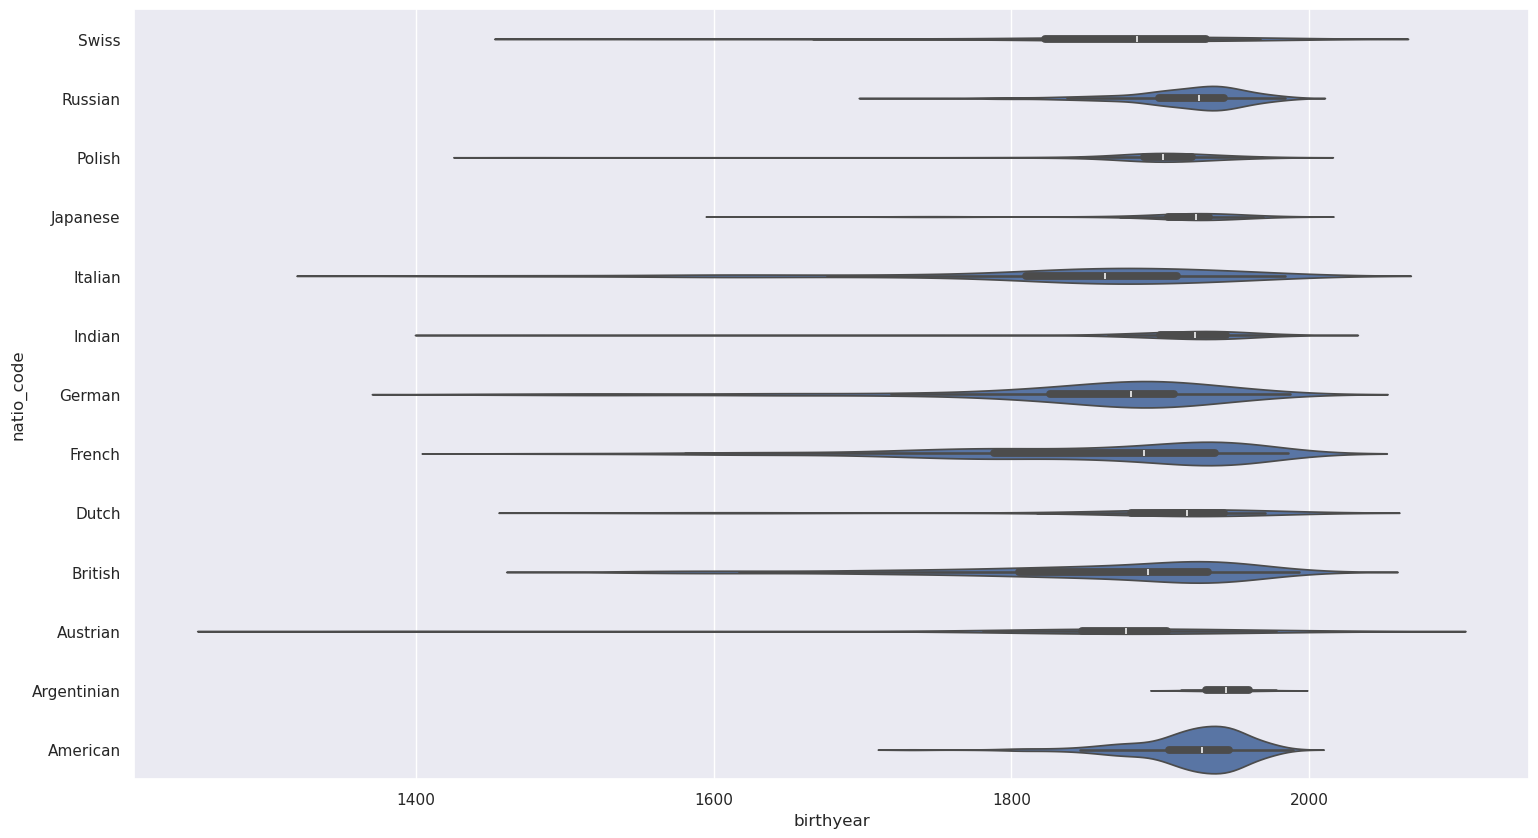

In [232]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

# with new density_norm argument 
sns.violinplot(y='natio_code', x='birthyear', density_norm='count', data=c_df.sort_values(by='natio_code', ascending=False))
plt.show()